In [1]:
# import sys
# sys.path.append('..')

In [2]:
from utility import load_dataset, load_model_with_ckpt, make_one_graph
import draw_utils

/opt/miniconda3/envs/SPGIE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision.transforms as VT

In [4]:
import os
from PIL import Image
import numpy as np

class mnistmData(torch.utils.data.Dataset):
    def __init__(self, root, mode='train', to_gray=False):
        '''
        Get Image Path.
        '''
        self.mode = mode # 'train' or 'test'

        root = os.path.expanduser(root)
        if mode == 'train':
            folder = os.path.join(root, 'mnist_m_train')
        else:
            folder = os.path.join(root, 'mnist_m_test')

        # generate imgs path
        imgs = [os.path.join(folder, img).replace('\\', '/') \
                for img in os.listdir(folder)]
        imgs = sorted(imgs, key=lambda img: int(img.split('/')[-1].split('.')[0]))
        imgs_num = len(imgs)
        self.imgs = imgs

        # generate labels
        label_file = 'mnist_m_{}_labels.txt'.format(mode)
        label_file = os.path.join(root, label_file)
        with open(label_file) as f:
            self.labels = [l[:-1].split(' ')[1] for l in f]

        # shape is 32x32
        # transforms
        trans = []
        if mode == 'train':
            trans += [
                VT.RandomCrop(28),
            ]
        else:
            trans += [
                VT.CenterCrop(28),
            ]
        trans += [VT.ToTensor()]
        
        self.transforms = VT.Compose(trans)

    def __getitem__(self, index):
        '''
        return one image's data
        if in test dataset, return image's id
        '''
        img_path = self.imgs[index]
        label = self.labels[index]
        label = int(label)

        data = Image.open(img_path)
        data = self.transforms(data)

        return data, label
    
    def get_all_imgs(self):
        imgs = [self[i][0].numpy() for i in range(len(self))]
        imgs = np.stack(imgs, 0).astype(np.float)
        return imgs

    def __len__(self):
        return len(self.imgs)

DATA_DIR = '~/data/'
ORIGIN_DATA_DIR = DATA_DIR + 'mnist_m/'
ori_dataset = mnistmData(ORIGIN_DATA_DIR, mode='train')

dataset = load_dataset('mnist_m', train=False)

----- Loading test dataset -----


In [5]:
# hidden_dim = 20
# ckpt_name = '/home/dragonchen/mlruns/0/c02d833566014cb0877882980a24f7f7/artifacts/best.pt'
hidden_dim = 64
ckpt_name = '/home/dragonchen/mlruns/0/b6c409724cbc4c6da8f703344d56dc58/artifacts/best.pt'
# hidden_dim = 128
# ckpt_name = '/home/dragonchen/mlruns/0/843a07bea5794a3787f90b9356395c43/artifacts/best.pt'
# hidden_dim = 256
# ckpt_name = '/home/dragonchen/mlruns/0/e367774683fa4f3e9e69e439b7aaf318/artifacts/best.pt'

aggr = 'add'
pool = 'max'

device = torch.device('cpu')
model = load_model_with_ckpt(
    input_dim=dataset.num_features,
    hidden_dim=hidden_dim,
    output_dim=dataset.num_classes,
    drn_k=4, aggr=aggr, pool=pool,
    device=device,
    ckpt_name=ckpt_name,
)

Pooling with max
Using self-loops
There are 2 aggregation layers


In [52]:
img_idx = 16
img_ori, lbl = ori_dataset[img_idx]
img_sp, node2map = make_one_graph(
    torch.permute(img_ori, (1, 2, 0)), channel_axis=2,
)
img_sp.y = torch.tensor(lbl)

In [53]:
# temp = dataset[0]
# temp = img_sp
# print(temp.x.dtype)
# print(temp.edge_index.dtype)
# print(temp.y.dtype)
# print(temp.pos.dtype)

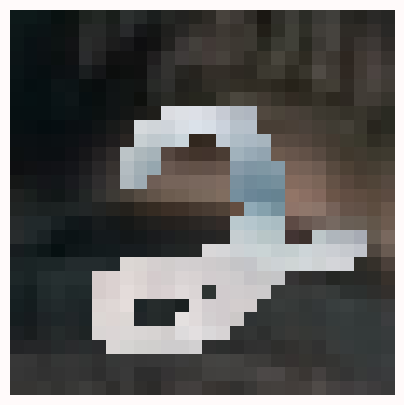

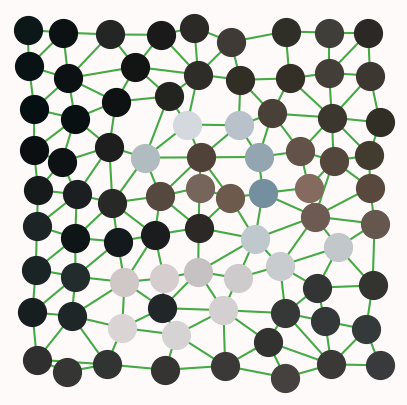

In [54]:
import matplotlib.pyplot as plt

# original
draw_utils.show_original(img_ori)

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2:],
    img_sp.edge_index,
)
plt.show()

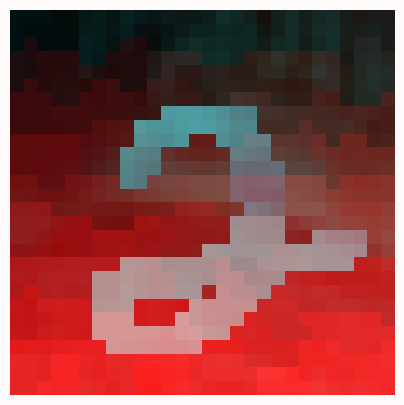

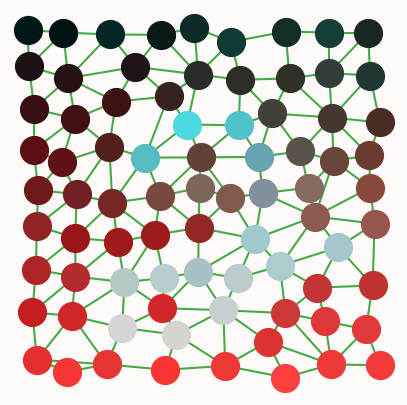

In [70]:
img_temp = img_ori.clone()

graph_size = img_sp.x.shape[0]

for node_idx in range(graph_size):
    m = node2map[node_idx]
    img_temp[:, m] = img_temp[:, m] * 0.7
    img_temp[0, m] = node_idx / graph_size

draw_utils.show_original(img_temp)

x_temp = img_sp.x.clone()
for node_idx in range(graph_size):
    x_temp[node_idx, 2] = node_idx / graph_size * 255

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, x_temp[:, 2:],
    img_sp.edge_index,
)
plt.show()

In [9]:
img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
img_sp = img_sp.to(device)

out = model(img_sp).detach().cpu()

print('true', lbl)
print('pred', out.argmax(1).item())

true 2
pred 0


In [10]:
# torch.manual_seed(1340)
for i, c in enumerate(torch.softmax(out, 1).tolist()[0]):
    print(f'{i} {c:.04f}')

0 0.9962
1 0.0006
2 0.0000
3 0.0000
4 0.0000
5 0.0000
6 0.0002
7 0.0015
8 0.0000
9 0.0015


In [11]:
import sys
sys.path.append('..')
from models.drn_train import test
from torch_geometric.loader import DataLoader

test_dev = torch.device('cuda:0')
loader = DataLoader(dataset, batch_size=128, shuffle=False)
acc, _ = test(model.to(test_dev), loader, device=test_dev, mlflow_log=False)
print(f'Got {acc * 100:.2f}% acc on testing set.')
model = model.to(device)

100%|██████████| 71/71 [00:02<00:00, 33.37it/s]

Got 94.13% acc on testing set.


## Start Explaining

In [12]:
from PIL import Image
plt.rcParams['figure.facecolor'] = '#fffafa'
import networkx as nx
from skimage.segmentation import slic, mark_boundaries

In [13]:
from models.jit_drn_model import (
    knn_graph, to_undirected, normalized_cut_2d,
    graclus_cluster,
#     aggr_pool, aggr_pool_x,
    global_pool_aggr
)

In [14]:
from torch_scatter import scatter
from torch_geometric.typing import OptTensor, Optional, Tuple
from torch import Tensor
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool.pool import pool_batch

def _aggr_pool_x(cluster, x, aggr: str, size: Optional[int] = None):
    """Call into scatter with configurable reduction op"""
    return scatter(x, cluster, dim=0, dim_size=size, reduce=aggr)

def global_pool_aggr(x, batch: OptTensor, aggr: str, size: Optional[int] = None):
    """Global pool via passed aggregator: 'mean', 'add', 'max'"""
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if batch is not None:
        size = int(batch.max().item() + 1)
    assert batch is not None
    return scatter(x, batch, dim=0, dim_size=size, reduce=aggr)

# this function is specialized compared to the more general non-jittable version
# in particular edge_attr can be removed since it is always None
def aggr_pool(cluster, x, batch: OptTensor, aggr: str) -> Tuple[Tensor, OptTensor]:
    """jit-friendly version of max/mean/add pool"""
    global node_hist
    print('c1', cluster.shape)
    print(cluster[:20])
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster[:20])
    print('perm', perm.shape)
    print('perm', perm[:10])
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })

    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)
    return x, batch

def aggr_pool_x(cluster, x, batch: OptTensor, aggr: str, size: Optional[int] = None) -> Tuple[Tensor, OptTensor]:
    """*_pool_x with configurable aggr method"""
    global node_hist
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if size is not None and batch is not None:
        batch_size = int(batch.max().item()) + 1
        return _aggr_pool_x(cluster, x, aggr, batch_size * size), None

    print('c1', cluster.shape)
    print(cluster)
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster)
    print('perm', perm.shape)
    print('perm', perm)
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })
    
    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)

    return x, batch

start x torch.Size([79, 64])
c1 torch.Size([79])
tensor([ 0,  1,  2,  3,  4,  3,  4,  7,  8,  9, 10, 11, 12, 13, 14, 15,  1, 17,
        18, 18])
c2 torch.Size([79])
tensor([ 0,  1,  2,  3,  4,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  1, 14,
        15, 15])
perm torch.Size([46])
perm tensor([36, 16, 38,  5,  6, 75, 40,  9, 10, 42])


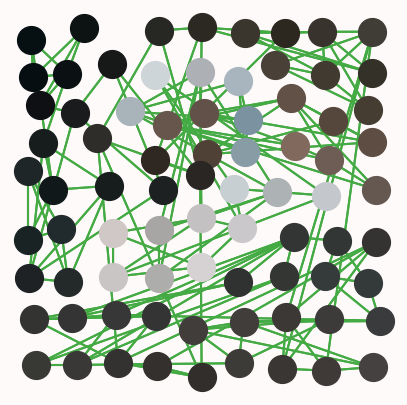

c1 torch.Size([46])
tensor([ 0,  1,  2,  2,  4,  5,  6,  7,  0,  9, 10, 11, 12, 13,  9,  6, 16, 17,
        13, 12, 20, 21, 22,  5, 21,  7, 26, 27, 11, 16, 27,  1,  4, 20, 34, 35,
        36, 37, 37, 39, 34, 41, 41, 39, 26, 45])
c2 torch.Size([46])
tensor([ 0,  1,  2,  2,  3,  4,  5,  6,  0,  7,  8,  9, 10, 11,  7,  5, 12, 13,
        11, 10, 14, 15, 16,  4, 15,  6, 17, 18,  9, 12, 18,  1,  3, 14, 19, 20,
        21, 22, 22, 23, 19, 24, 24, 23, 17, 25])
perm torch.Size([26])
perm tensor([ 8, 31,  3, 32, 23, 15, 25, 14, 10, 28, 19, 18, 29, 17, 33, 24, 22, 44,
        30, 40, 35, 36, 38, 43, 42, 45])
global x tensor([[ -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,
          -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,
          -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,
          -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  87.8387,
          -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000,  -4.0000, 

[[-0.0062851859256625175,
  -6.711557865142822,
  -16.386932373046875,
  -15.347647666931152,
  -16.391775131225586,
  -15.642969131469727,
  -7.953701496124268,
  -6.256704330444336,
  -10.88404369354248,
  -5.892347812652588]]

In [15]:
import torch.nn.functional as F

torch.manual_seed(100)

drn = model.drn # get the model layer
x = img_sp.x
batch = img_sp.batch

# draw_superpixel_from_graph(x, gd.edge_index)

x = drn.datanorm * x
x = drn.inputnet(x)

nAgg = len(drn.agg_layers)

node_hist = []
print(f'start x', x.shape)
node_hist.append({'x': x.detach().cpu()})
for i, edgeconv in enumerate(drn.agg_layers):
    knn = knn_graph(x, drn.k, batch, loop=drn.loop, flow=edgeconv.flow)
#     print(f'i {i} knn', knn.shape)
    edge_index = to_undirected(knn)
#     print(x.T)
#     plot_x(x)
    x = edgeconv(x, edge_index)
#     print(x.T)
#     plot_x(x)
    
#     print(f'i {i} edge conv', x.shape)

    weight = normalized_cut_2d(edge_index, x)
    cluster = graclus_cluster(edge_index[0], edge_index[1], weight, x.size(0))
#     print(f'i {i} cluster', cluster.shape)

    if i == nAgg - 1:
        x, batch = aggr_pool_x(cluster, x, batch, drn.aggr_type)
    else:
        x, batch = aggr_pool(cluster, x, batch, drn.aggr_type)
    
    # extract history node
#     hist = cluster.tolist()
# #     print('h', hist)
#     node_hist.append(torch.tensor(hist))
    xx = img_sp.x.cpu()
    ee = edge_index.cpu()
#     print('h', hist)
#     print('ee', ee)
    node_hist.append({'x': x.detach().cpu()})
    
    if i == 0:
        draw_utils.draw_superpixel_from_graph(
            xx[:, :2], xx[:, 2:], ee
        )


# print('b', batch)
x = global_pool_aggr(x, batch, drn.aggr_type)
print('global x', x)
node_hist.append({'global_x': x.detach().cpu()})

# print(f'global x', x.shape)

out = drn.output(x).squeeze(-1)
out = F.log_softmax(out, dim=1)
out.tolist()

In [16]:
# print([n.keys() for n in node_hist])
# for n in node_hist:
#     print('-----layer-----')
#     for k in n:
#         print(k, n[k].shape)

In [17]:
# from global x to layer2
from collections import defaultdict
counter = defaultdict(int)
basenode_values = defaultdict(list)
xx2 = node_hist[-2]['x']

gx = node_hist[-1]['global_x'].squeeze()
for i, g in enumerate(gx.tolist()):
    if g > 0:
        xx2k = xx2[:, i].tolist().index(g)
        counter[xx2k] += 1
        basenode_values[xx2k].append(g)
print('counter', counter)
print('basenode_imp', basenode_values)

basenode_imp = {}
for k, v in basenode_values.items():
    print('k', k, end=' ')
    avg = sum(v) / len(v)
    print('avg', avg)
    basenode_imp[k] = avg

counter defaultdict(<class 'int'>, {5: 1, 6: 1, 15: 1})
basenode_imp defaultdict(<class 'list'>, {5: [87.83871459960938], 6: [13.151023864746094], 15: [307.41217041015625]})
k 5 avg 87.83871459960938
k 6 avg 13.151023864746094
k 15 avg 307.41217041015625


In [21]:
# pick those nodes be refered multiple times
l1 = node_hist[1]
l2 = node_hist[3]

final_nodes = [n for n in counter if counter[n] >= 1] # there !
final_nodes

[5, 6, 15]

In [22]:
# base on nodes do softmax on basenode_imp
temp_keys = [k for k in basenode_imp if k in final_nodes]
print('keys', temp_keys)
temp_values = [v for k, v in basenode_imp.items() if k in final_nodes]
print('values', temp_values)

x = temp_values

# # softmax
# temp_values = torch.softmax(torch.tensor(x), dim=0).tolist()
# print('new', temp_values)

# min-max
min_v = np.min(x)
max_v = np.max(x)
temp_values = (x - min_v) / (max_v - min_v)
print('new', temp_values)

# put it back
basenode_imp = dict(zip(temp_keys, temp_values))

keys [5, 6, 15]
values [87.83871459960938, 13.151023864746094, 307.41217041015625]
new [0.25381431 0.         1.        ]


In [23]:
basenode_track = {} # record basenode mapping

nodes_l2 = []
for n in final_nodes:
    idx = l2['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l2['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l2['c2']))[l2['c2'] == c].tolist()
    print('nodes', nodes)
    
    for cn in nodes: # child node
        basenode_track[cn] = c
    
    nodes_l2 += nodes
nodes_l2

15
c 5
nodes [6, 15]
25
c 6
nodes [7, 25]
24
c 15
nodes [21, 24]


[6, 15, 7, 25, 21, 24]

In [24]:
temp_track = {}

nodes_l1 = []
for n in nodes_l2:
    idx = l1['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l1['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l1['c2']))[l1['c2'] == c].tolist()
    print('nodes', nodes)
    
    for cn in nodes: # child node
        temp_track[cn] = basenode_track[c] # extrac parent's basenode into child node
    
    nodes_l1 += nodes
basenode_track = temp_track
nodes_l1

40
c 6
nodes [8, 40]
19
c 15
nodes [18, 19]
9
c 7
nodes [9]
33
c 25
nodes [33]
54
c 21
nodes [27, 54]
44
c 24
nodes [32, 44]


[8, 40, 18, 19, 9, 33, 27, 54, 32, 44]

## Draw

In [25]:
import random
color_set = {
    v: [random.randint(0, 255) for _ in range(3)]
    for _, v in basenode_track.items()
}

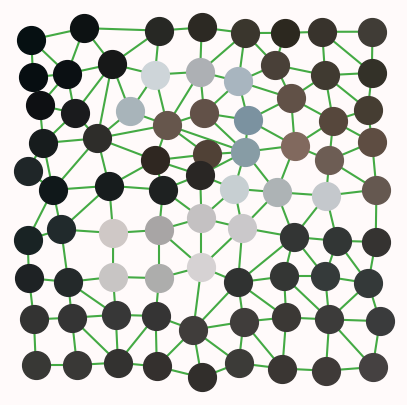

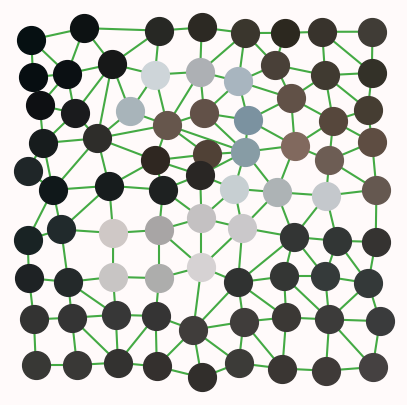

In [32]:
# use old function print
import numpy as np
pos = img_sp.x[:, :2].cpu().numpy()
# pos = np.flip(pos, 1)
rgb = img_sp.x[:, 2:].cpu().numpy()
draw_utils.draw_superpixel_from_graph(
    pos, rgb, img_sp.edge_index, multi_graph=False,
)

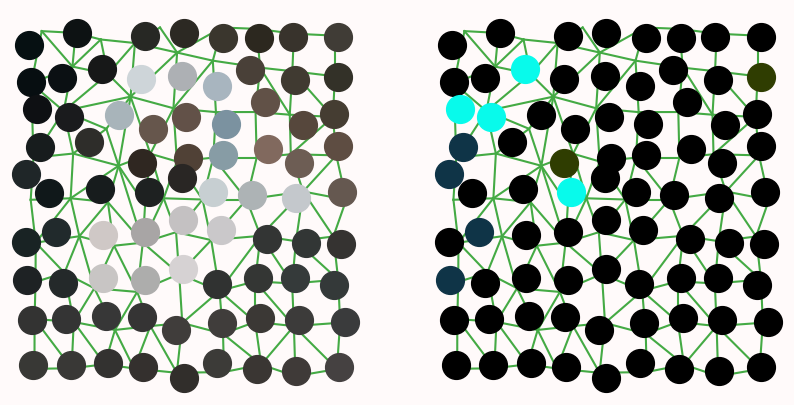

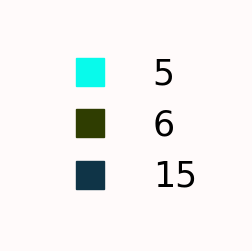

In [34]:
# old function print original, forus and basenode highlight
img = img_sp
pos = img.x[:, :2].cpu().numpy()
rgb = img.x[:, 2:].cpu().numpy()

# # single colour
# imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
# for n in nodes_l1:
#     imp[n][1] = 150

# basenode track
imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n] = color_set[basenode_track[n]]

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp], img.edge_index, multi_graph=True,
)

# color_set
plt.figure(figsize=(3, 3))
colors = ['#{:02x}{:02x}{:02x}'.format(*c) for n, c in color_set.items()]
f = lambda m,c: plt.plot([],[],marker=m, markersize=20, color=c, ls="none")[0]
handles = [f("s", c) for c in colors]
labels = [n for n, _ in color_set.items()]
legend = plt.legend(
    handles, labels,
    loc='center', framealpha=1, frameon=False,
    fontsize=25,
)
plt.axis('off')
# plt.show()
plt.savefig('demo1.svg')

true 2
pred 0


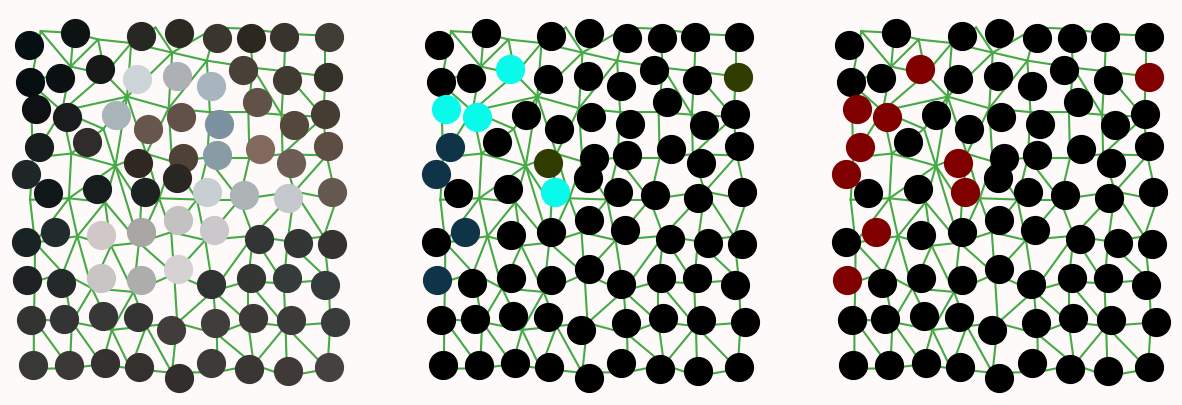

temp (3, 28, 28)


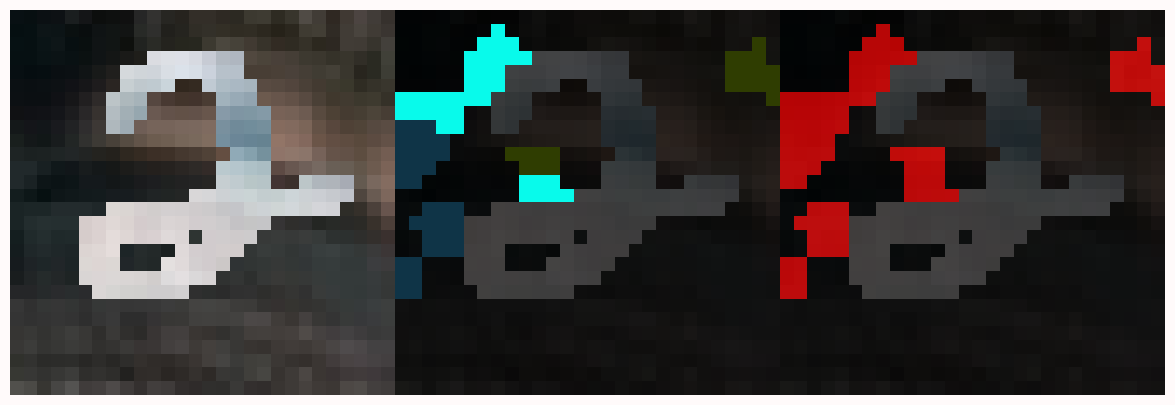

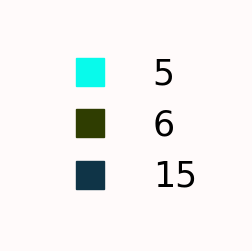

In [35]:
print('true', lbl)
print('pred', out.argmax(1).item())

# print rgb, basenode and imp
pos = img.x[:, :2].cpu().numpy()
rgb = img.x[:, 2:].cpu().numpy()

# # single colour
# imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
# for n in nodes_l1:
#     imp[n][1] = 150

# basenode track
imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n] = color_set[basenode_track[n]]

# basenode imp
imp2 = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
#     c = int(basenode_imp[basenode_track[n]] * 255)
#     imp2[n][1] = c
    imp2[n][0] = 128

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp, imp2], img.edge_index, multi_graph=True,
)
# util.draw_superpixel_from_graph(pos, [rgb, imp2], img, multi_graph=True)


img_temp1 = img_ori.numpy().copy()
img_temp1 = img_temp1 * 0.3
img_temp2 = img_temp1.copy()

print('temp', img_temp1.shape)
for n in nodes_l1:
    m = node2map[n]
    
    replace_color = np.array(color_set[basenode_track[n]])
    replace_color = np.expand_dims(replace_color, axis=1)
    img_temp1[:, m] = replace_color / 255
    img_temp2[0, m] += 0.7

img_out = np.concatenate([img_ori, img_temp1, img_temp2], axis=2)
# img_out = np.concatenate([img_ori, img_temp2], axis=2)
# print('out', img_out.shape)
draw_utils.show_original(img_out, width=15)


# color_set
plt.figure(figsize=(3, 3))
colors = ['#{:02x}{:02x}{:02x}'.format(*c) for n, c in color_set.items()]
f = lambda m,c: plt.plot([],[],marker=m, markersize=20, color=c, ls="none")[0]
handles = [f("s", c) for c in colors]
labels = [n for n, _ in color_set.items()]
legend = plt.legend(
    handles, labels,
    loc='center', framealpha=1, frameon=False,
    fontsize=25,
)
plt.axis('off')
plt.show()